**Aluno:** Lelson Lopes Nascimento

**Discipina:** Deep Learning 

**Curso:** Especialização em Ciência de Dados

**Professor:** Carlos Maurício Serodio Figueiredo


**Resumo:**

Esta atividade visa comparar uma implementação com CNN e uma usando transfer learning para aprendizado sobre avaliação de imagens de Raio-x de pulmão. 


**Data set:** https://www.kaggle.com/jtiptj/chest-xray-pneumoniacovid19tuberculosis



# Inicialização

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,Activation
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

2023-02-09 13:31:59.682055: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Lendo o dataset

In [3]:
# Alguns parâmetros para leitura do dataset
im_shape = (200,200)

TRAINING_DIR = '../input/chest-xray-pneumoniacovid19tuberculosis/train'
TEST_DIR = '../input/chest-xray-pneumoniacovid19tuberculosis/test'
VAL_DIR = '../input/chest-xray-pneumoniacovid19tuberculosis/val'

seed = 10
BATCH_SIZE = 16

In [5]:
#Using keras ImageGenerator and flow_from_directoty

# Image dataset 
# With augmentation

# data_generator = ImageDataGenerator(
#        validation_split=0.2, rotation_range=5, width_shift_range=0.05,
#        height_shift_range=0.05, preprocessing_function=preprocess_input,
#        zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

# Image dataset 
# Without augmentation
data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [6]:

# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(VAL_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 5061 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


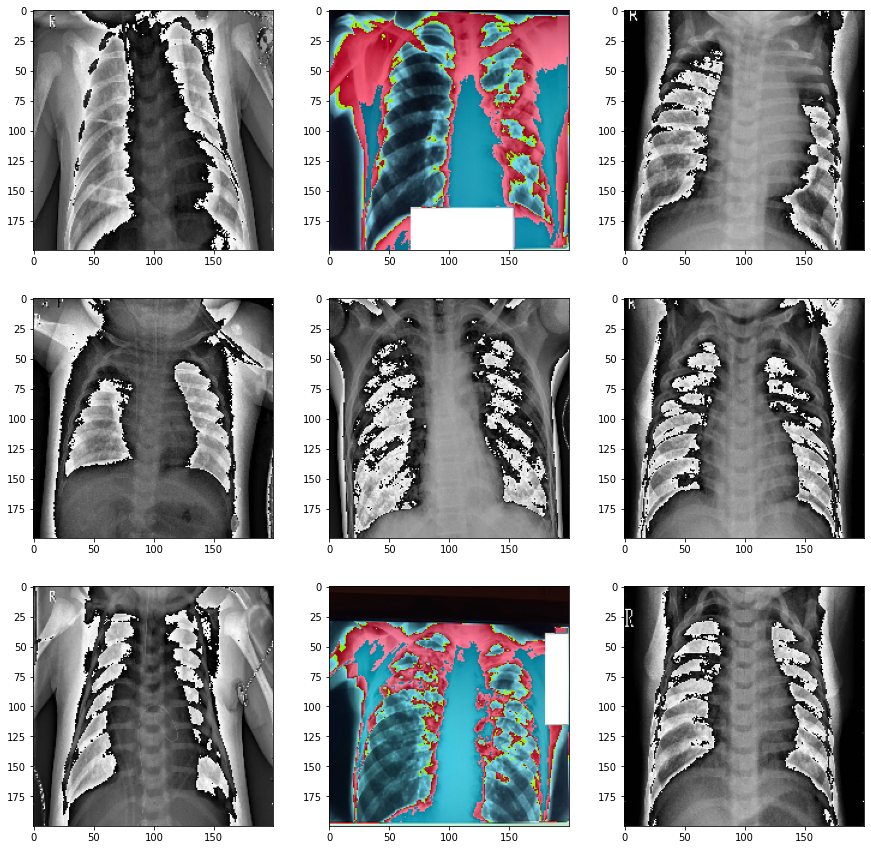

In [7]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# Uso de CNN com Augmentation

In [8]:
modelcnn = Sequential()
modelcnn.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(im_shape[0],im_shape[1],3)))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Dropout(0.2))
modelcnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Flatten())
modelcnn.add(Dense(100, activation='relu'))
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(num_classes, activation='softmax'))
modelcnn.summary()

modelcnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

2023-02-09 13:33:13.263343: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-09 13:33:13.268585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-09 13:33:13.331042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:33:13.331771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-02-09 13:33:13.331830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-09 13:33:13.359824: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0

In [10]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelcnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1)
]

In [11]:
results = modelcnn.fit_generator(train_generator, epochs=50,validation_data=validation_generator, callbacks = [callbacks_list])

2023-02-09 13:33:57.276138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-09 13:33:57.279657: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/50


2023-02-09 13:33:57.813898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-09 13:33:58.683719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-02-09 13:33:58.707356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


317/317 [==============================] - 116s 346ms/step - loss: 0.6008 - accuracy: 0.7892 - val_loss: 0.1056 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.10556, saving model to modelcnn.h5
Epoch 2/50
317/317 [==============================] - 61s 193ms/step - loss: 0.1714 - accuracy: 0.9395 - val_loss: 0.0779 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.10556 to 0.07791, saving model to modelcnn.h5
Epoch 3/50
317/317 [==============================] - 61s 193ms/step - loss: 0.1152 - accuracy: 0.9666 - val_loss: 0.1208 - val_accuracy: 0.8333

Epoch 00003: val_loss did not improve from 0.07791
Epoch 4/50
317/317 [==============================] - 61s 191ms/step - loss: 0.0794 - accuracy: 0.9728 - val_loss: 0.0259 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.07791 to 0.02586, saving model to modelcnn.h5
Epoch 5/50
317/317 [==============================] - 61s 194ms/step - loss: 0.0533 - accuracy: 0.9818 - val_loss: 0.0268 - val

In [9]:
epochs = 50

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelcnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1)
]

#Training
history = modelcnn.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/50
316/316 [==============================] - 96s 303ms/step - loss: 0.2846 - accuracy: 0.9058
Epoch 2/50
316/316 [==============================] - 61s 194ms/step - loss: 0.1450 - accuracy: 0.9506
Epoch 3/50
316/316 [==============================] - 61s 193ms/step - loss: 0.1060 - accuracy: 0.9617
Epoch 4/50
316/316 [==============================] - 61s 193ms/step - loss: 0.0783 - accuracy: 0.9732
Epoch 5/50
316/316 [==============================] - 61s 193ms/step - loss: 0.0545 - accuracy: 0.9812
Epoch 6/50
316/316 [==============================] - 60s 190ms/step - loss: 0.0547 - accuracy: 0.9804
Epoch 7/50
316/316 [==============================] - 61s 192ms/step - loss: 0.0472 - accuracy: 0.9816
Epoch 8/50
316/316 [==============================] - 61s 194ms/step - loss: 0.0275 - accuracy: 0.9909
Epoch 9/50
316/316 [==============================] - 62s 195ms/step - loss: 0.0256 - accuracy: 0.9903
Epoch 10/50
316/316 [==============================] - 63s 200ms/step - l

In [46]:
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [14]:
import pandas as pd

In [15]:
from tensorflow.keras.models import load_model
losses = pd.DataFrame(modelcnn.history.history)

In [16]:
modelcnn.metrics_names

['loss', 'accuracy']

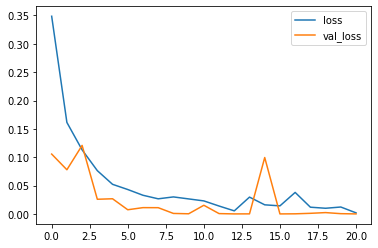

In [17]:
losses[['loss','val_loss']].plot()
plt.show()

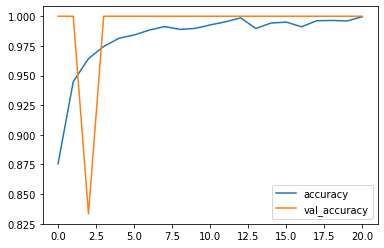

In [18]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [50]:
# Load the best saved model
from tensorflow.keras.models import load_model

#model = load_model('../input/classify-food-datas-models/model.h5')
#modelcnn = load_model('modelcnn.h5')
score = modelcnn.evaluate_generator(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\n\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = modelcnn.evaluate_generator(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])



Val loss: 0.05110863968729973
Val accuracy: 1.0

Test loss: 3.1540141105651855
Test accuracy: 0.765239953994751


In [47]:
print(score)

[3.1540141105651855, 0.765239953994751]


In [19]:
import itertools
#Gera matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report
               precision    recall  f1-score   support

      COVID19       0.96      0.86      0.91       106
       NORMAL       0.92      0.42      0.58       234
    PNEUMONIA       0.75      0.99      0.85       390
TURBERCULOSIS       0.68      0.95      0.80        41

     accuracy                           0.80       771
    macro avg       0.83      0.80      0.78       771
 weighted avg       0.83      0.80      0.77       771



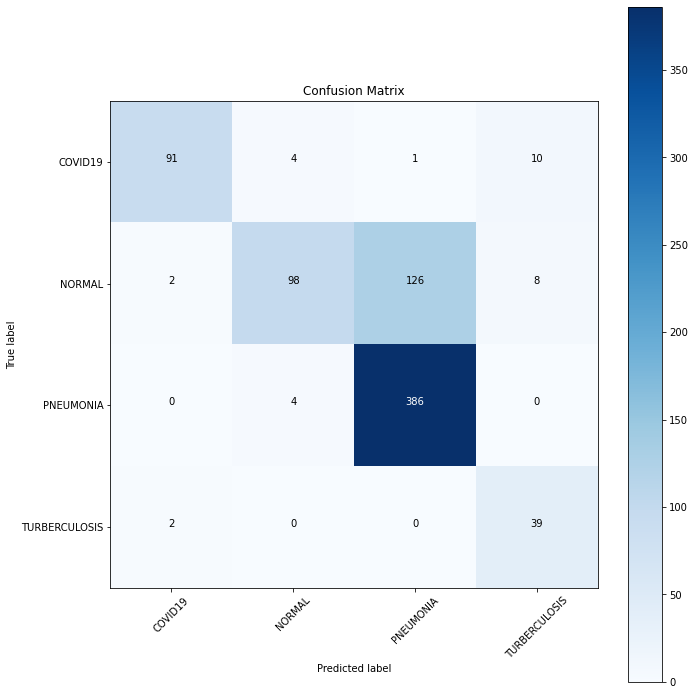

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = modelcnn.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

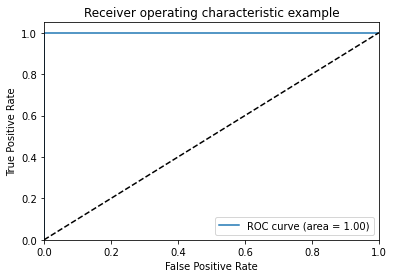

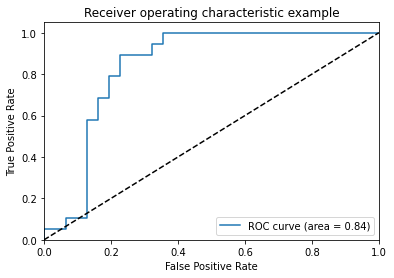

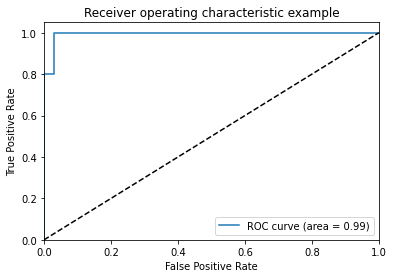

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X, y = iris.data, iris.target

y = label_binarize(y, classes=[0,1,2])
n_classes = 3


X_train, X_test, Y_train, Y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0)


clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, Y_train).decision_function(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Transfer Learning from a Deep Model

In [ ]:
#Using keras ImageGenerator and flow_from_directoty

# Image dataset 
# With augmentation

# Image dataset 
# With augmentation

# data_generator = ImageDataGenerator(
#        validation_split=0.2, rotation_range=5, width_shift_range=0.05,
#        height_shift_range=0.05, preprocessing_function=preprocess_input,
#        shear_range=0.05,
#        zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

# Image dataset 
# Without augmentation
data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator( preprocessing_function=preprocess_input,validation_split=0.2)

In [ ]:

# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(VAL_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

In [ ]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(120, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

modeltrf = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
modeltrf.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs = 10

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modeltrf.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = modeltrf.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

In [ ]:
# from tensorflow.keras.models import load_model
# Load the best saved model
# model = load_model('modeltrf.h5')

In [ ]:
# Using the validation dataset
score = modeltrf.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

In [ ]:
# Using the test dataset
score = modeltrf.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = modeltrf.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))